In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
import acquisition_function as acqf
import discrete_mes as mes
import discrete_ucb as ucb
import discrete_ei as ei
import discrete_pi as pi


%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# agrmax(target) = 2
def target(x):
    return (3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1) )+torch.randn(x.size()) * .1

# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function with Gaussian noise N(0,0.01)
train_y = Variable(target(train_x))

#true target (unknown)
x = torch.linspace(-5, 15, 1000)
y = target(x)
torch.is_tensor(x)

True

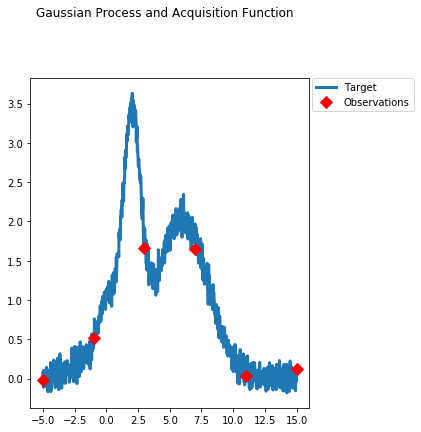

In [3]:
# plotting gp 
def plot_gp(train_x, train_y, x, y, rand_var=None, model=False, acq = None, bo=False):
    fig = plt.figure(figsize=(5,10))
    gs = gridspec.GridSpec(2,1,height_ratios=[2, 1]) 
    axis = plt.subplot(gs[0])
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(train_x, train_y, 'D', markersize=8, label=u'Observations', color='r')
    fig.suptitle('Gaussian Process and Acquisition Function',fontdict={'size':30})
    # if model is trained 
    if model == True:
        lower, upper = rand_var.confidence_region()
        mean = rand_var.mean().data.numpy()
        var = rand_var.var().data.numpy()
        axis.plot(x, mean, '--', color='k', label='Prediction')
       # axis.fill_between(x, lower.data.numpy(), upper.data.numpy(), alpha=.6, label='95% confidence interval')
        axis.fill_between(x, y - 1.96 * var , y + 1.96 * var, alpha=.3, label='95% confidence interval')
    
    # if acqusition function is available
    if bo == True:
        acqusition = plt.subplot(gs[1])
        acqusition.plot(x, acq.data.numpy(), label='Utility Function', color='purple')
        acqusition.plot(x[torch.argmax(acq)], torch.max(acq).data.numpy(), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
        acqusition.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
# target function and observations 
plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy())

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return model output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [5]:
# train model to get the hypeparameters 
def train_model(model,train_x,train_y):   
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 10
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        '''
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.data[0],
            model.covar_module.log_lengthscale.data[0, 0],
            model.likelihood.log_noise.data[0]
        ))
        '''
        optimizer.step()


In [6]:
# predict
def eval_model(model,likelihood):   
    # Put model and likelihood into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with gpytorch.fast_pred_var():
        observed_pred = likelihood(model(x))
    return observed_pred

In [7]:
'''
#acquisition function using upper confidence bound 
def ucb(observed_pred, kappa=5):
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    acq = mean + kappa * std
    return acq,torch.argmax(acq)

# expected improvement 
def ei(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = (mean - y_max) * Normal(0,1).cdf(z) + std * Normal(0,1).log_prob(z).exp()
    return acq, torch.argmax(acq)

# probability of improvement
def poi(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = Normal(0,1).cdf(z) 
    return acq, torch.argmax(acq)



# max value entropy search
def mesi(observed_pred):
    with gpytorch.beta_features.fast_pred_var(), gpytorch.beta_features.fast_pred_samples():
    
        f_samples = observed_pred.sample(100)
        y_star_sample = f_samples.max(dim=0)

        y_max = y_star_sample[0].repeat(1000,1).t()

        mean = observed_pred.mean()
        std = torch.sqrt(observed_pred.var())

        gamma = (y_max - mean ) / std
        acq =  gamma * Normal(0,1).log_prob(gamma).exp() / (2 *  Normal(0,1).cdf(gamma)) - torch.log(Normal(0,1).cdf(gamma))

        acq = acq.sum(dim =0) / 100
        index = torch.argmax(acq)

    return acq, index
'''

'\n#acquisition function using upper confidence bound \ndef ucb(observed_pred, kappa=5):\n    mean = observed_pred.mean()\n    std = torch.sqrt(observed_pred.var())\n    acq = mean + kappa * std\n    return acq,torch.argmax(acq)\n\n# expected improvement \ndef ei(observed_pred, train_y):\n    y_max = torch.max(train_y)\n    mean = observed_pred.mean()\n    std = torch.sqrt(observed_pred.var())\n    z = (mean - y_max) / std\n    acq = (mean - y_max) * Normal(0,1).cdf(z) + std * Normal(0,1).log_prob(z).exp()\n    return acq, torch.argmax(acq)\n\n# probability of improvement\ndef poi(observed_pred, train_y):\n    y_max = torch.max(train_y)\n    mean = observed_pred.mean()\n    std = torch.sqrt(observed_pred.var())\n    z = (mean - y_max) / std\n    acq = Normal(0,1).cdf(z) \n    return acq, torch.argmax(acq)\n\n\n\n# max value entropy search\ndef mesi(observed_pred):\n    with gpytorch.beta_features.fast_pred_var(), gpytorch.beta_features.fast_pred_samples():\n    \n        f_samples = ob

In [8]:
train_x = Variable(torch.linspace(-5, 15, 6))
train_y = Variable(target(train_x))
train_inputs = (torch.ones(2),)
likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
model = ExactGPModel(train_x.data, train_y.data, likelihood)
t = torch.ones(2)
print(t)
print(t.ndimension())
print(t.unsqueeze(-1))
print(tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in train_inputs))
print(train_x.dtype)

tensor([ 1.,  1.])
1
tensor([[ 1.],
        [ 1.]])
(tensor([[ 1.],
        [ 1.]]),)
torch.float32


In [9]:
'''
likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
train_inputs = torch.ones(4,5)
train_inputs = tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in train_inputs)
print(train_inputs)
model = ExactGPModel(train_x.data, train_y.data, likelihood)

train_model(model,train_x,train_y)
print(model.train_targets)
for param in model.parameters():
    assert param.grad is not None 
    assert param.grad.norm().item()> 0
'''

'\nlikelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))\ntrain_inputs = torch.ones(4,5)\ntrain_inputs = tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in train_inputs)\nprint(train_inputs)\nmodel = ExactGPModel(train_x.data, train_y.data, likelihood)\n\ntrain_model(model,train_x,train_y)\nprint(model.train_targets)\nfor param in model.parameters():\n    assert param.grad is not None \n    assert param.grad.norm().item()> 0\n'

before size torch.Size([6])
after size torch.Size([7])
model.train_inputs: (tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.7898]]),)
train_x tensor([ -5.0000,  -1.0000,   3.0000,   7.0000,  11.0000,  15.0000,
          4.7898])
wtf tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.7898]]) tensor(-5.)
before size torch.Size([7])
after size torch.Size([8])
model.train_inputs: (tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.7898],
        [  2.2673]]),)
train_x tensor([ -5.0000,  -1.0000,   3.0000,   7.0000,  11.0000,  15.0000,
          4.7898,   2.2673])
wtf tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.7898],
        [  2.2673]]) tensor(-5.)
before s

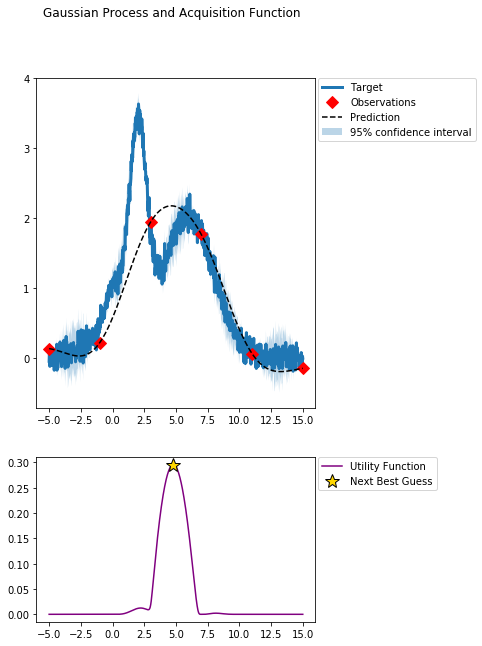

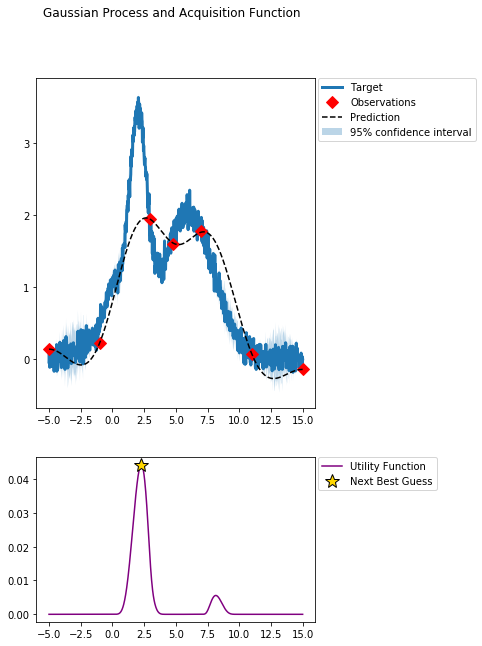

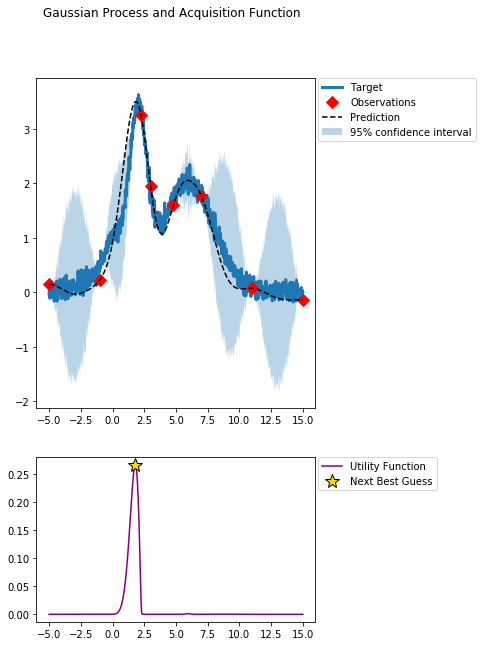

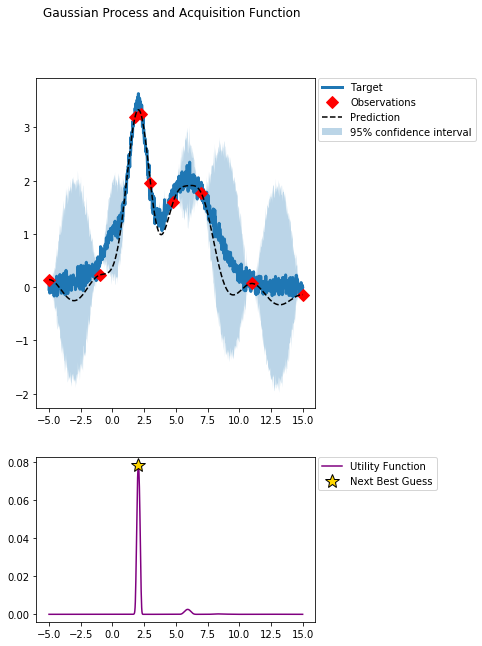

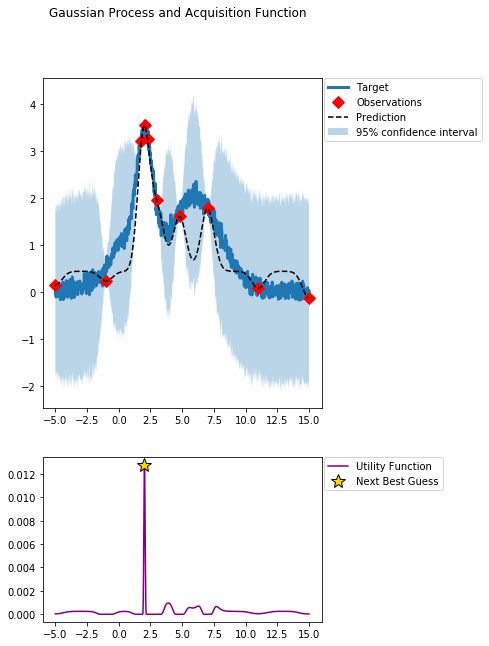

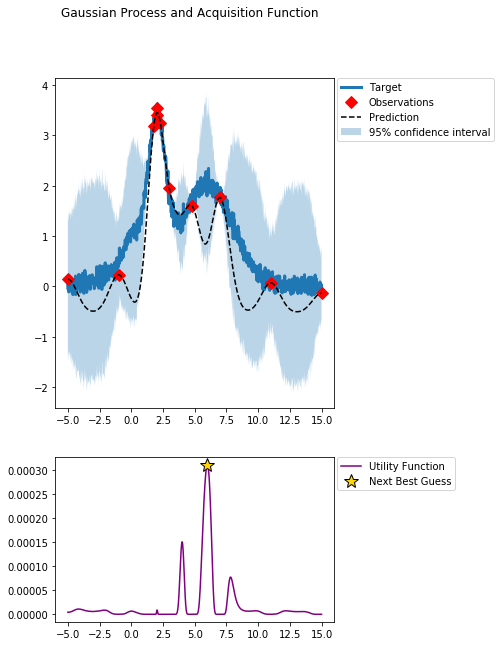

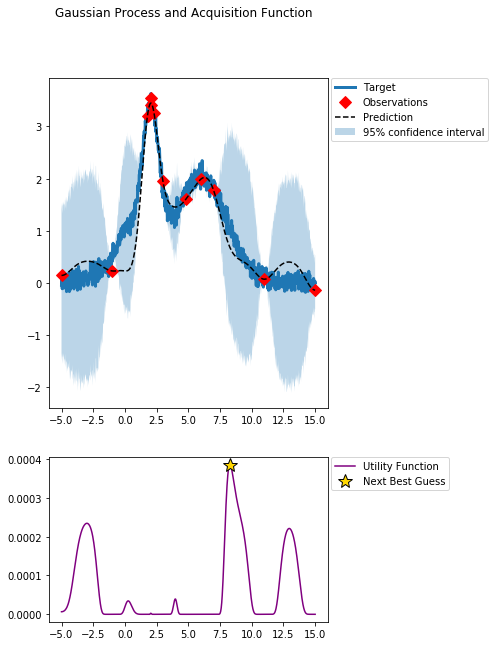

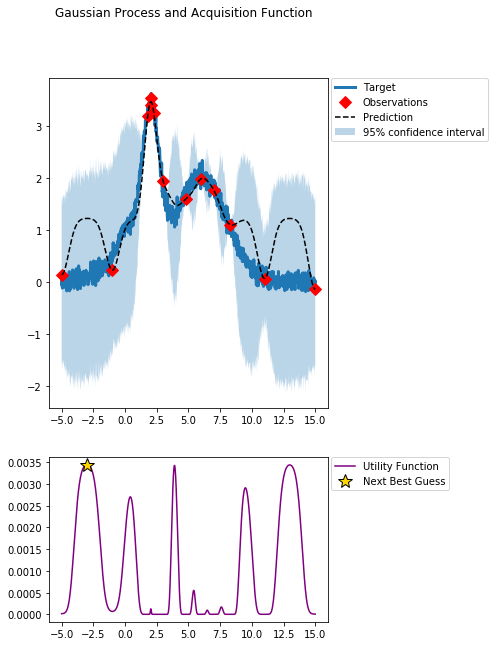

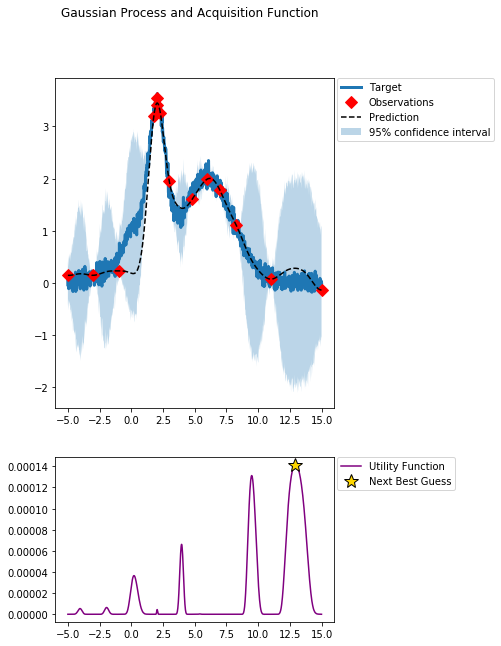

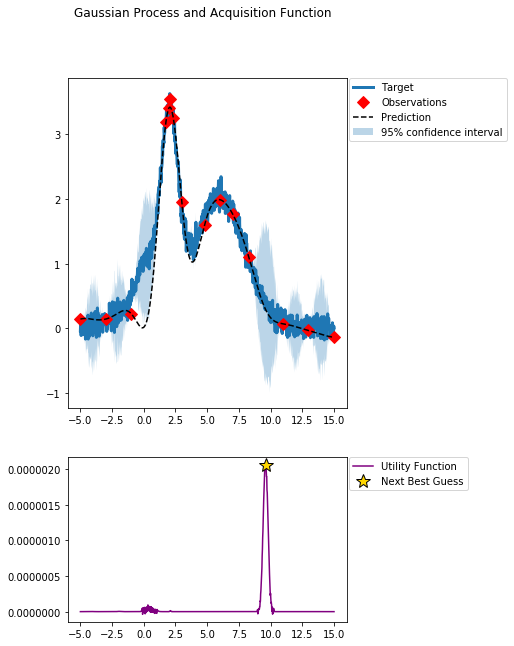

In [10]:
likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
model = ExactGPModel(train_x.data, train_y.data, likelihood)

iteration = 10
for i in range(iteration):
    # initialize likelihood and model
    #likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
    #model = ExactGPModel(train_x, train_y, likelihood)

    #train model
    train_model(model,train_x,train_y)
    model.eval()
    likelihood.eval()
    observed_pred = eval_model(model,likelihood)
    #choose acquisition function 

    #utility = mes.DiscreteMES(model,nK=100)
    #utility = pi.DiscretePI(model,train_y)
    utility = ei.DiscreteEI(model,train_y)
    #utility = ucb.DiscreteUCB(model, kappa=5)
    
    
    
    #acq,index = ucb(observed_pred)
    #acq,index = ei(observed_pred,train_y)
    #acq,index = poi(observed_pred,train_y)
    #acq,index = mesi(observed_pred)

    acq, xx = utility(x)


    #xx = Variable(x[index]).view(1)
    yy = target(xx)
    plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy(), observed_pred, True, acq, True)

    # append the next best guess into training set 
    train_x = Variable(torch.cat((train_x,xx)))
    train_inp = tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in (train_x,))
    train_y = Variable(torch.cat((train_y,yy)))    
    print("before size", model.train_targets.size())
    model.set_train_data(inputs=train_inp,targets=train_y,strict=False)
    print("after size", model.train_targets.size())
    print("model.train_inputs:",model.train_inputs)
    print("train_x",train_x)
    for train_input, input in zip(model.train_inputs, train_x):
        print("wtf",train_input,input)


In [11]:
torch.cuda.current_device()

3